# Hyper Parameter Optimization For GradientBoostingRegression

In [1]:
# import libraries
import os
import sys
import numpy as np
import pandas as pd
# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
MODEL_NAME = 'GBR'

In [2]:
current_path = os.getcwd()
current_path

'/output/workspace/Band-gap-predict/SingleModels/GBR'

In [3]:
# To import the custom module from a specific path
sys.path.insert(0, os.path.join(current_path, '../../'))
# Importing the custom module
from Utools.SingleModel import SingleModel

In [23]:
from sklearn.base import clone
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

## Load Data

In [5]:
# Load data
file_dir = os.path.join(current_path, '../../Data/composition_data/feature_data')
# dft data
dft_train = pd.read_csv(os.path.join(file_dir, 'dft', 'train.csv'))
dft_test = pd.read_csv(os.path.join(file_dir, 'dft', 'test.csv'))
# exp data
exp_train = pd.read_csv(os.path.join(file_dir, 'exp', 'train.csv'))
exp_test = pd.read_csv(os.path.join(file_dir, 'exp', 'test.csv'))

dft_train_X = dft_train.drop(columns=['composition', 'band_gap'])
dft_train_y = dft_train['band_gap']
exp_train_X = exp_train.drop(columns=['composition', 'band_gap'])
exp_train_y = exp_train['band_gap']
dft_test_X = dft_test.drop(columns=['composition', 'band_gap'])
dft_test_y = dft_test['band_gap']
exp_test_X = exp_test.drop(columns=['composition', 'band_gap'])
exp_test_y = exp_test['band_gap']

## Model Train

### DFT Model

In [29]:
# using random search to find the best hyperparameters for the dft model
print(f"['DFT {MODEL_NAME}'] HP optimization begin...")

# create a pipeline with a scaler and the model
gbr_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('gbr', GradientBoostingRegressor(random_state=RANDOM_SEED))
])

# define the parameter distributions  for the KNN model(total 675 combinations)
param_distributions = {
    'gbr__n_estimators': [100, 200, 500],
    'gbr__learning_rate': [0.01, 0.05, 0.1],
    'gbr__max_depth': [3, 4, 5, 7, 10],
    'gbr__max_features': ['sqrt', 'log2', 0.25, 0.5, 1],
    'gbr__subsample': [0.5, 0.75, 1],
}
# create a KFold object for cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

# create a randomized search CV object
# using n_iter=50 for a faster search, you can increase this for better results(n_iter=5, runtime=1.3min)
# forget to assign metrics score, the default is R2 score
random_search = RandomizedSearchCV(estimator=gbr_pipe, param_distributions=param_distributions,
                n_iter=500, cv=kf, verbose=1, random_state=RANDOM_SEED, 
                scoring='neg_mean_squared_error', return_train_score=True,  n_jobs=-1)

# fit the model to the training data
random_search.fit(dft_train_X, dft_train_y)

['DFT GBR'] HP optimization begin...
Fitting 5 folds for each of 500 candidates, totalling 2500 fits


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('gbr',
                                              GradientBoostingRegressor(random_state=42))]),
                   n_iter=500, n_jobs=-1,
                   param_distributions={'gbr__learning_rate': [0.01, 0.05, 0.1],
                                        'gbr__max_depth': [3, 4, 5, 7, 10],
                                        'gbr__max_features': ['sqrt', 'log2',
                                                              0.25, 0.5, 1],
                                        'gbr__n_estimators': [100, 200, 500],
                                        'gbr__subsample': [0.5, 0.75, 1]},
                   random_state=42, return_train_score=True,
                   scoring='neg_mean_squared_error', verbose=1)

In [30]:
# get the best hyperparameters
best_params = random_search.best_params_
print(f"Best Hyperparameters: {best_params}")
best_score = np.sqrt(-random_search.best_score_)
print(f"Best Cross-Validation RMSE: {best_score:.4f}")

# create a DataFrame to store the results
results = pd.DataFrame(random_search.cv_results_)
results['test_rmse'] = np.sqrt(-results['mean_test_score'])
results['train_rmse'] = np.sqrt(-results['mean_train_score'])
# sort the results by test RMSE
results_sorted = results.sort_values('test_rmse')
results_sorted = results_sorted[['rank_test_score', 'param_gbr__n_estimators', 'param_gbr__max_depth', 
                                 'param_gbr__learning_rate', 'param_gbr__max_features', 'param_gbr__subsample', 'train_rmse', 'test_rmse']]
# save the results to a csv file
hp_path = os.path.join(current_path, 'hp_search')
os.makedirs(hp_path, exist_ok=True)
results_sorted.to_csv(os.path.join(hp_path, 'dft_hp_results.csv'), index=False)
results_sorted.head()

Best Hyperparameters: {'gbr__subsample': 1, 'gbr__n_estimators': 500, 'gbr__max_features': 0.25, 'gbr__max_depth': 10, 'gbr__learning_rate': 0.05}
Best Cross-Validation RMSE: 0.7008


,rank_test_score,param_gbr__n_estimators,param_gbr__max_depth,param_gbr__learning_rate,param_gbr__max_features,param_gbr__subsample,train_rmse,test_rmse
409,1,500,10,0.05,0.25,1.00,0.275427,0.700805
447,2,500,10,0.05,0.5,1.00,0.279760,0.702367
396,3,500,10,0.05,log2,1.00,0.285966,0.705664
280,4,500,10,0.05,0.5,0.75,0.313332,0.706382
200,5,500,10,0.05,0.25,0.75,0.309746,0.706943


### Overfitting check

####################################################################################################
[DFT - GBR] Training GBR on DFT data:
----------------------------------------------------------------------------------------------------
Starting model training...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total= 3.1min
Model training completed!
[Train_error] Evaluating DFT GBR on DFT train set:


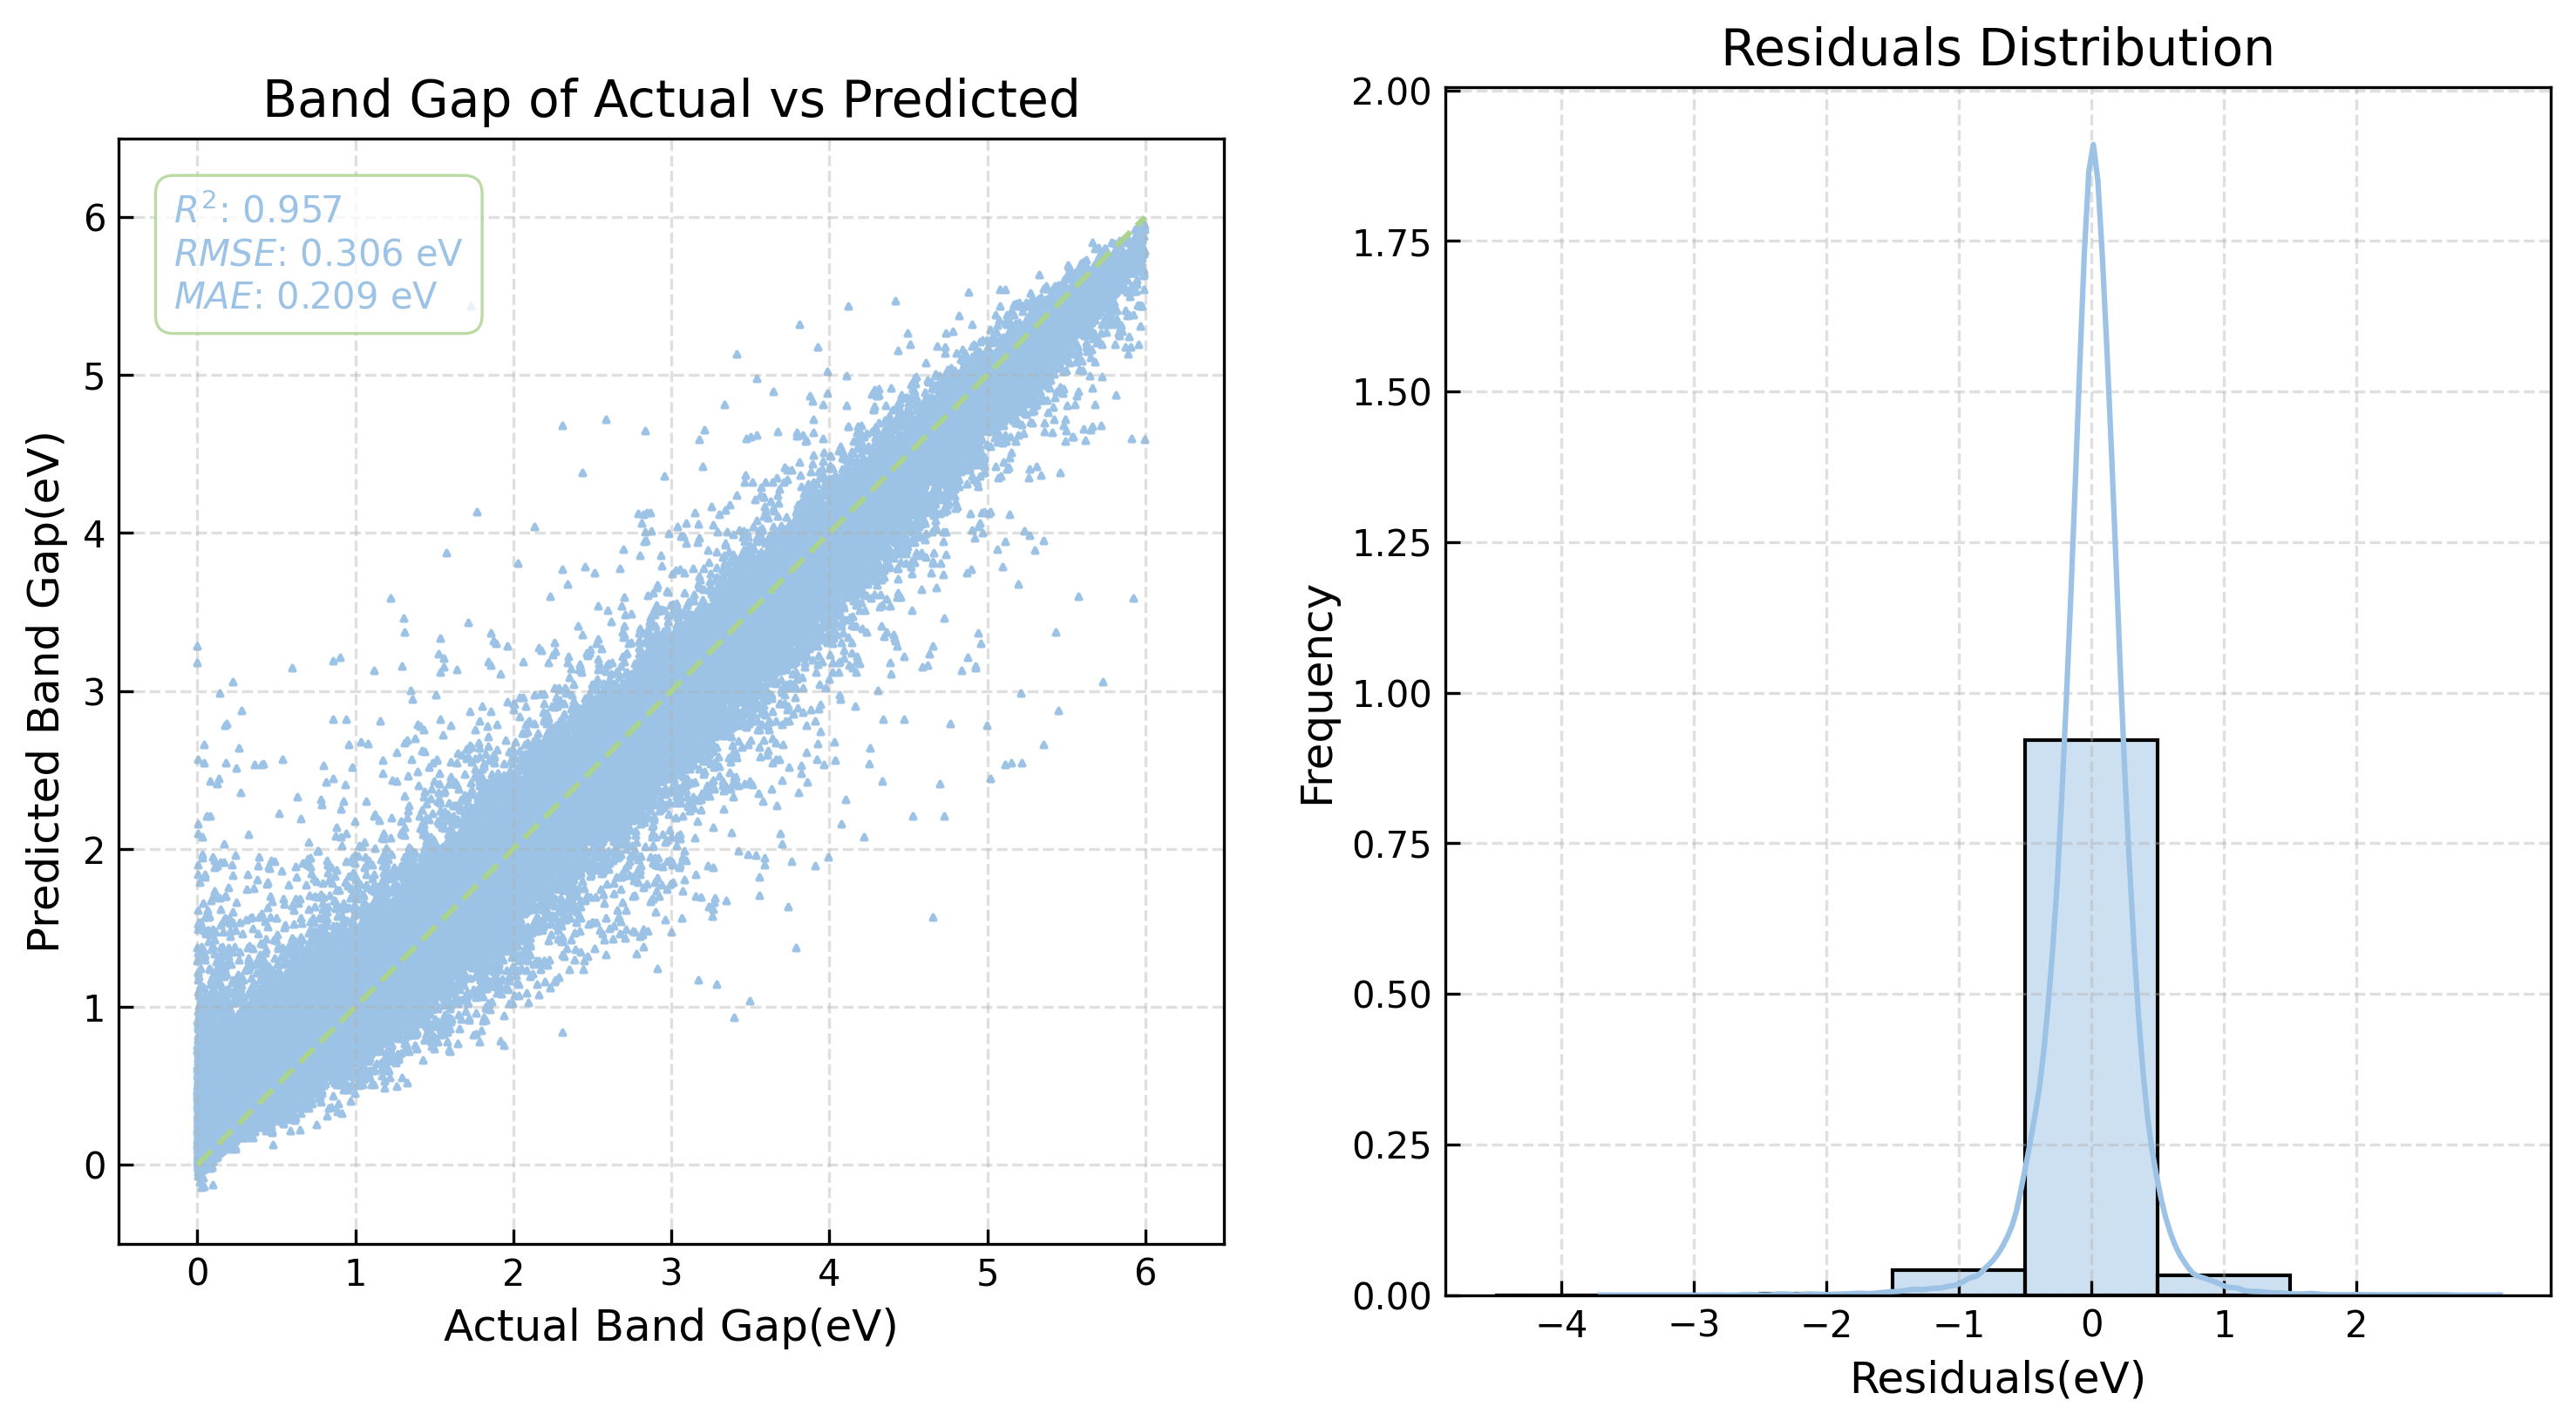


Model Evaluation Results:
Test set: R²: 0.9570 RMSE: 0.3060 MAE: 0.2088
[Test DFT -> DFT] Evaluating DFT GBR on DFT test set:


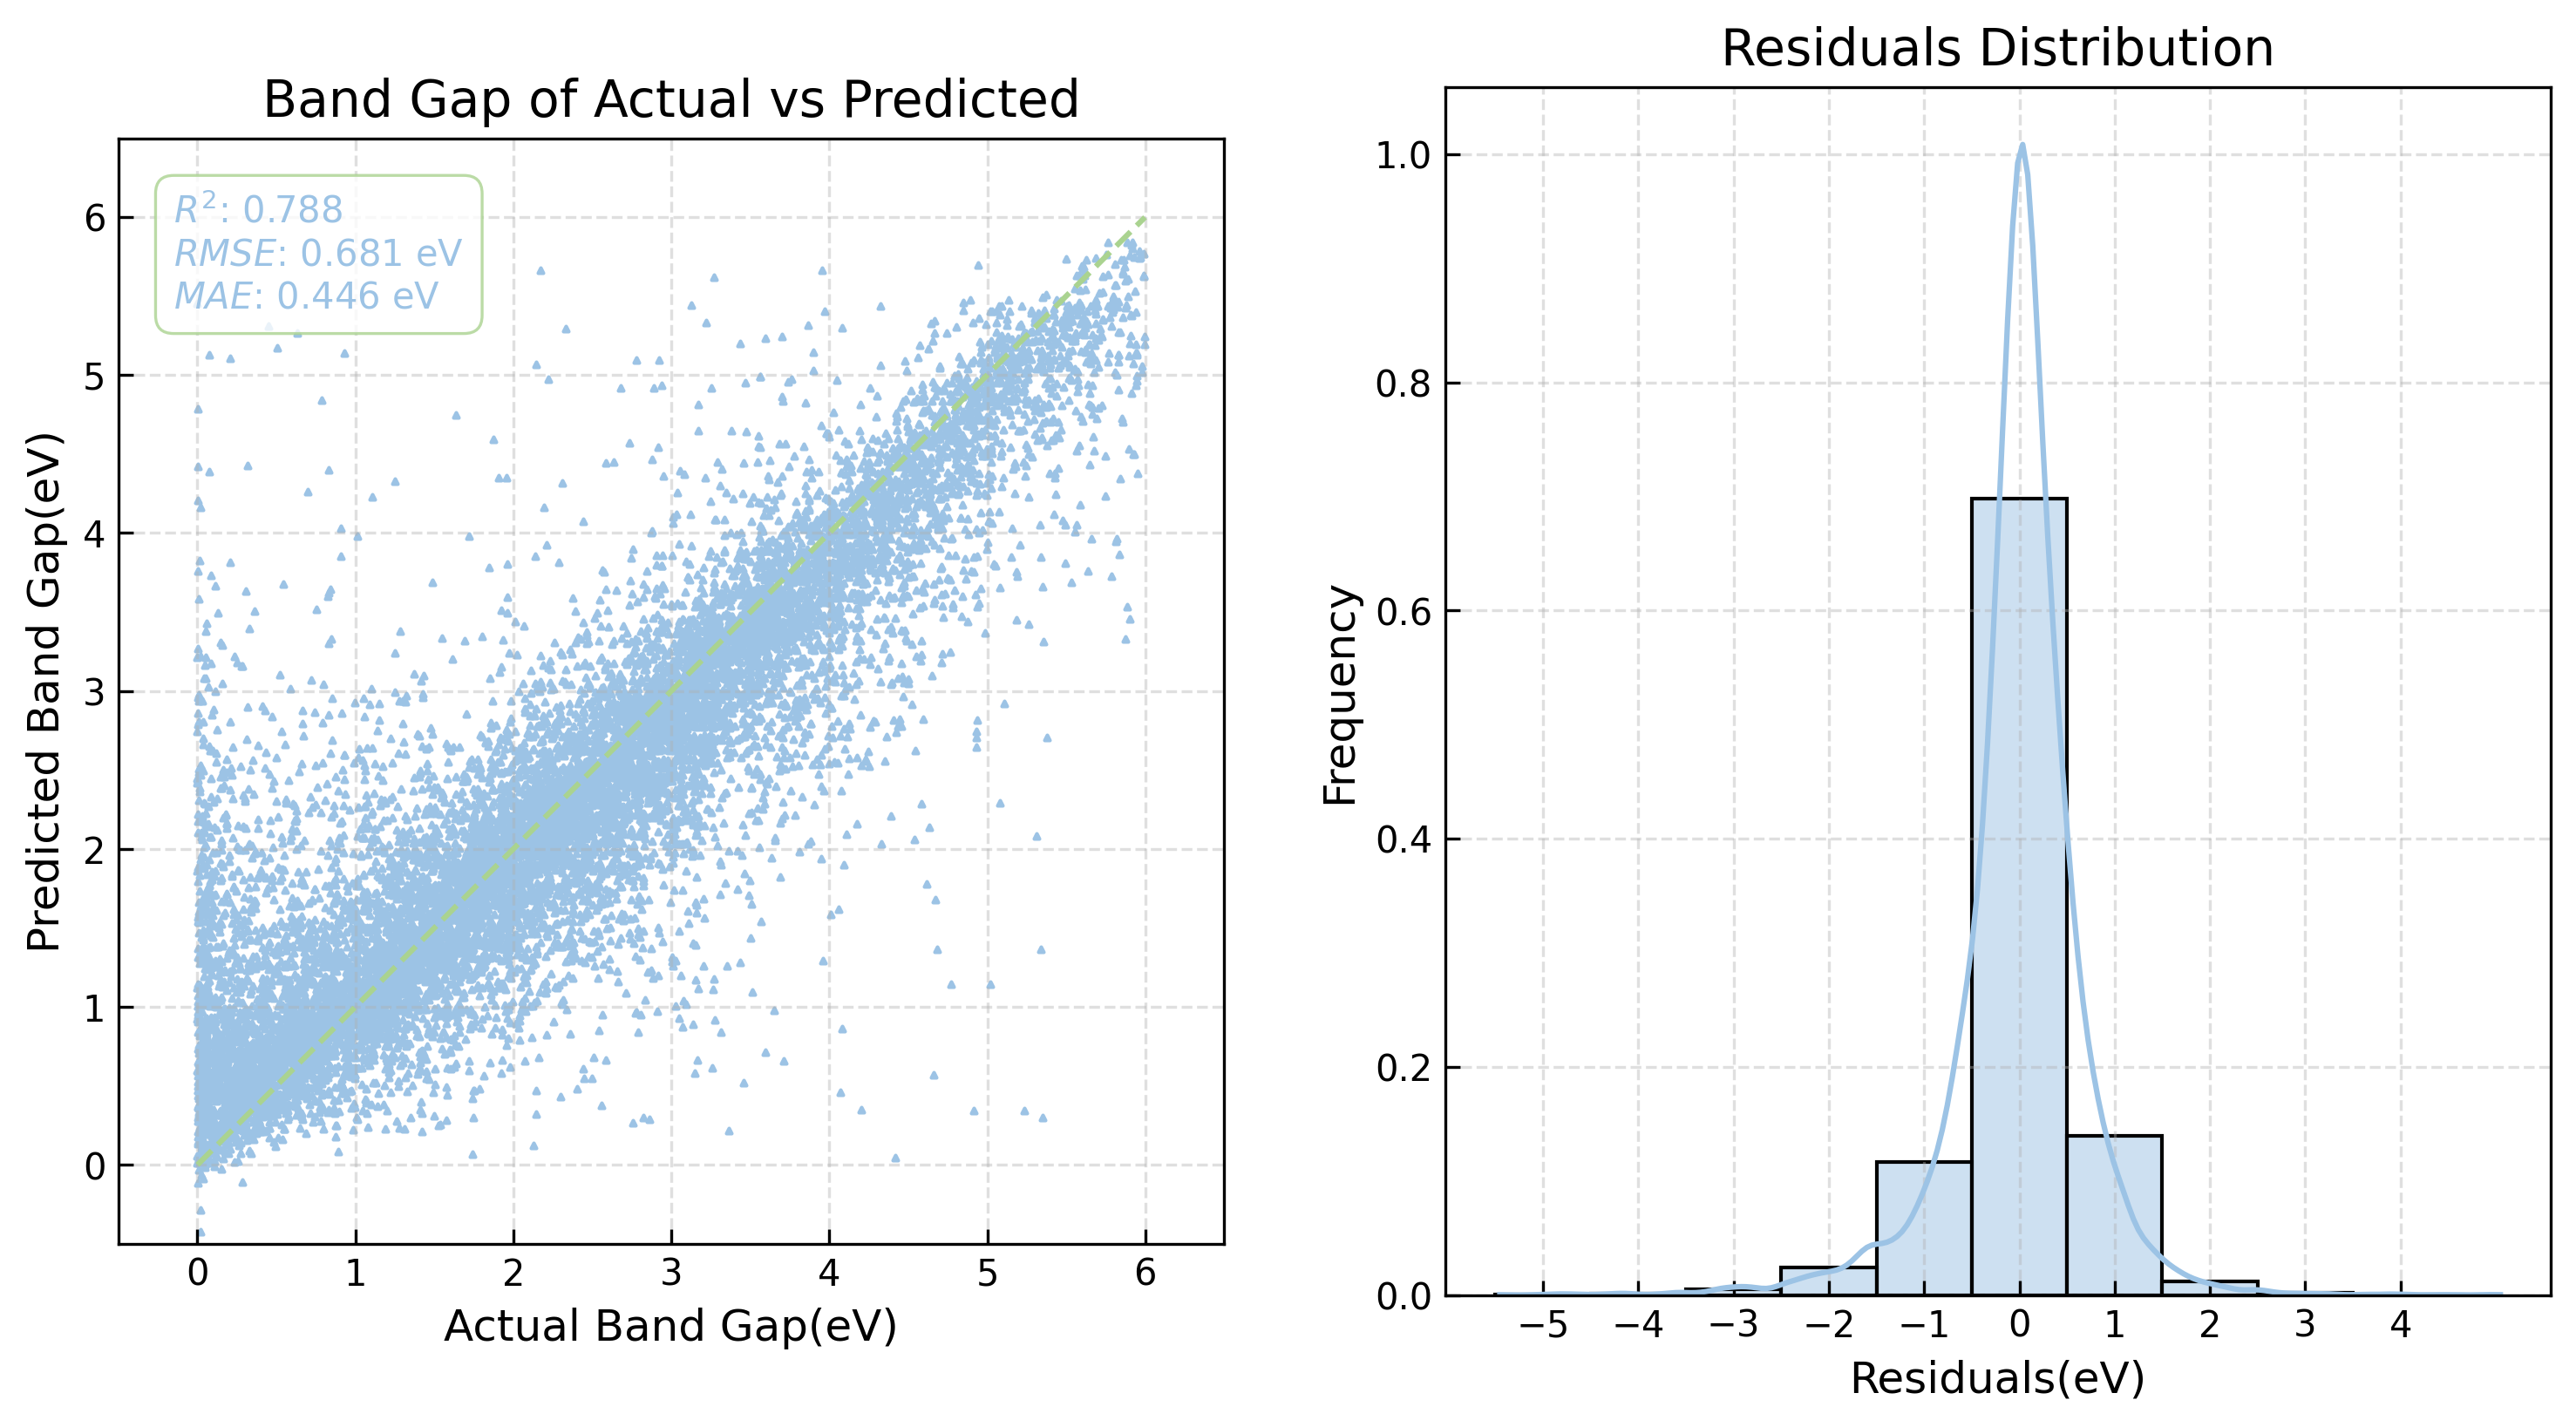


Model Evaluation Results:
Test set: R²: 0.7878 RMSE: 0.6810 MAE: 0.4460
[Test DFT -> EXP] Evaluating DFT GBR on EXP test set:


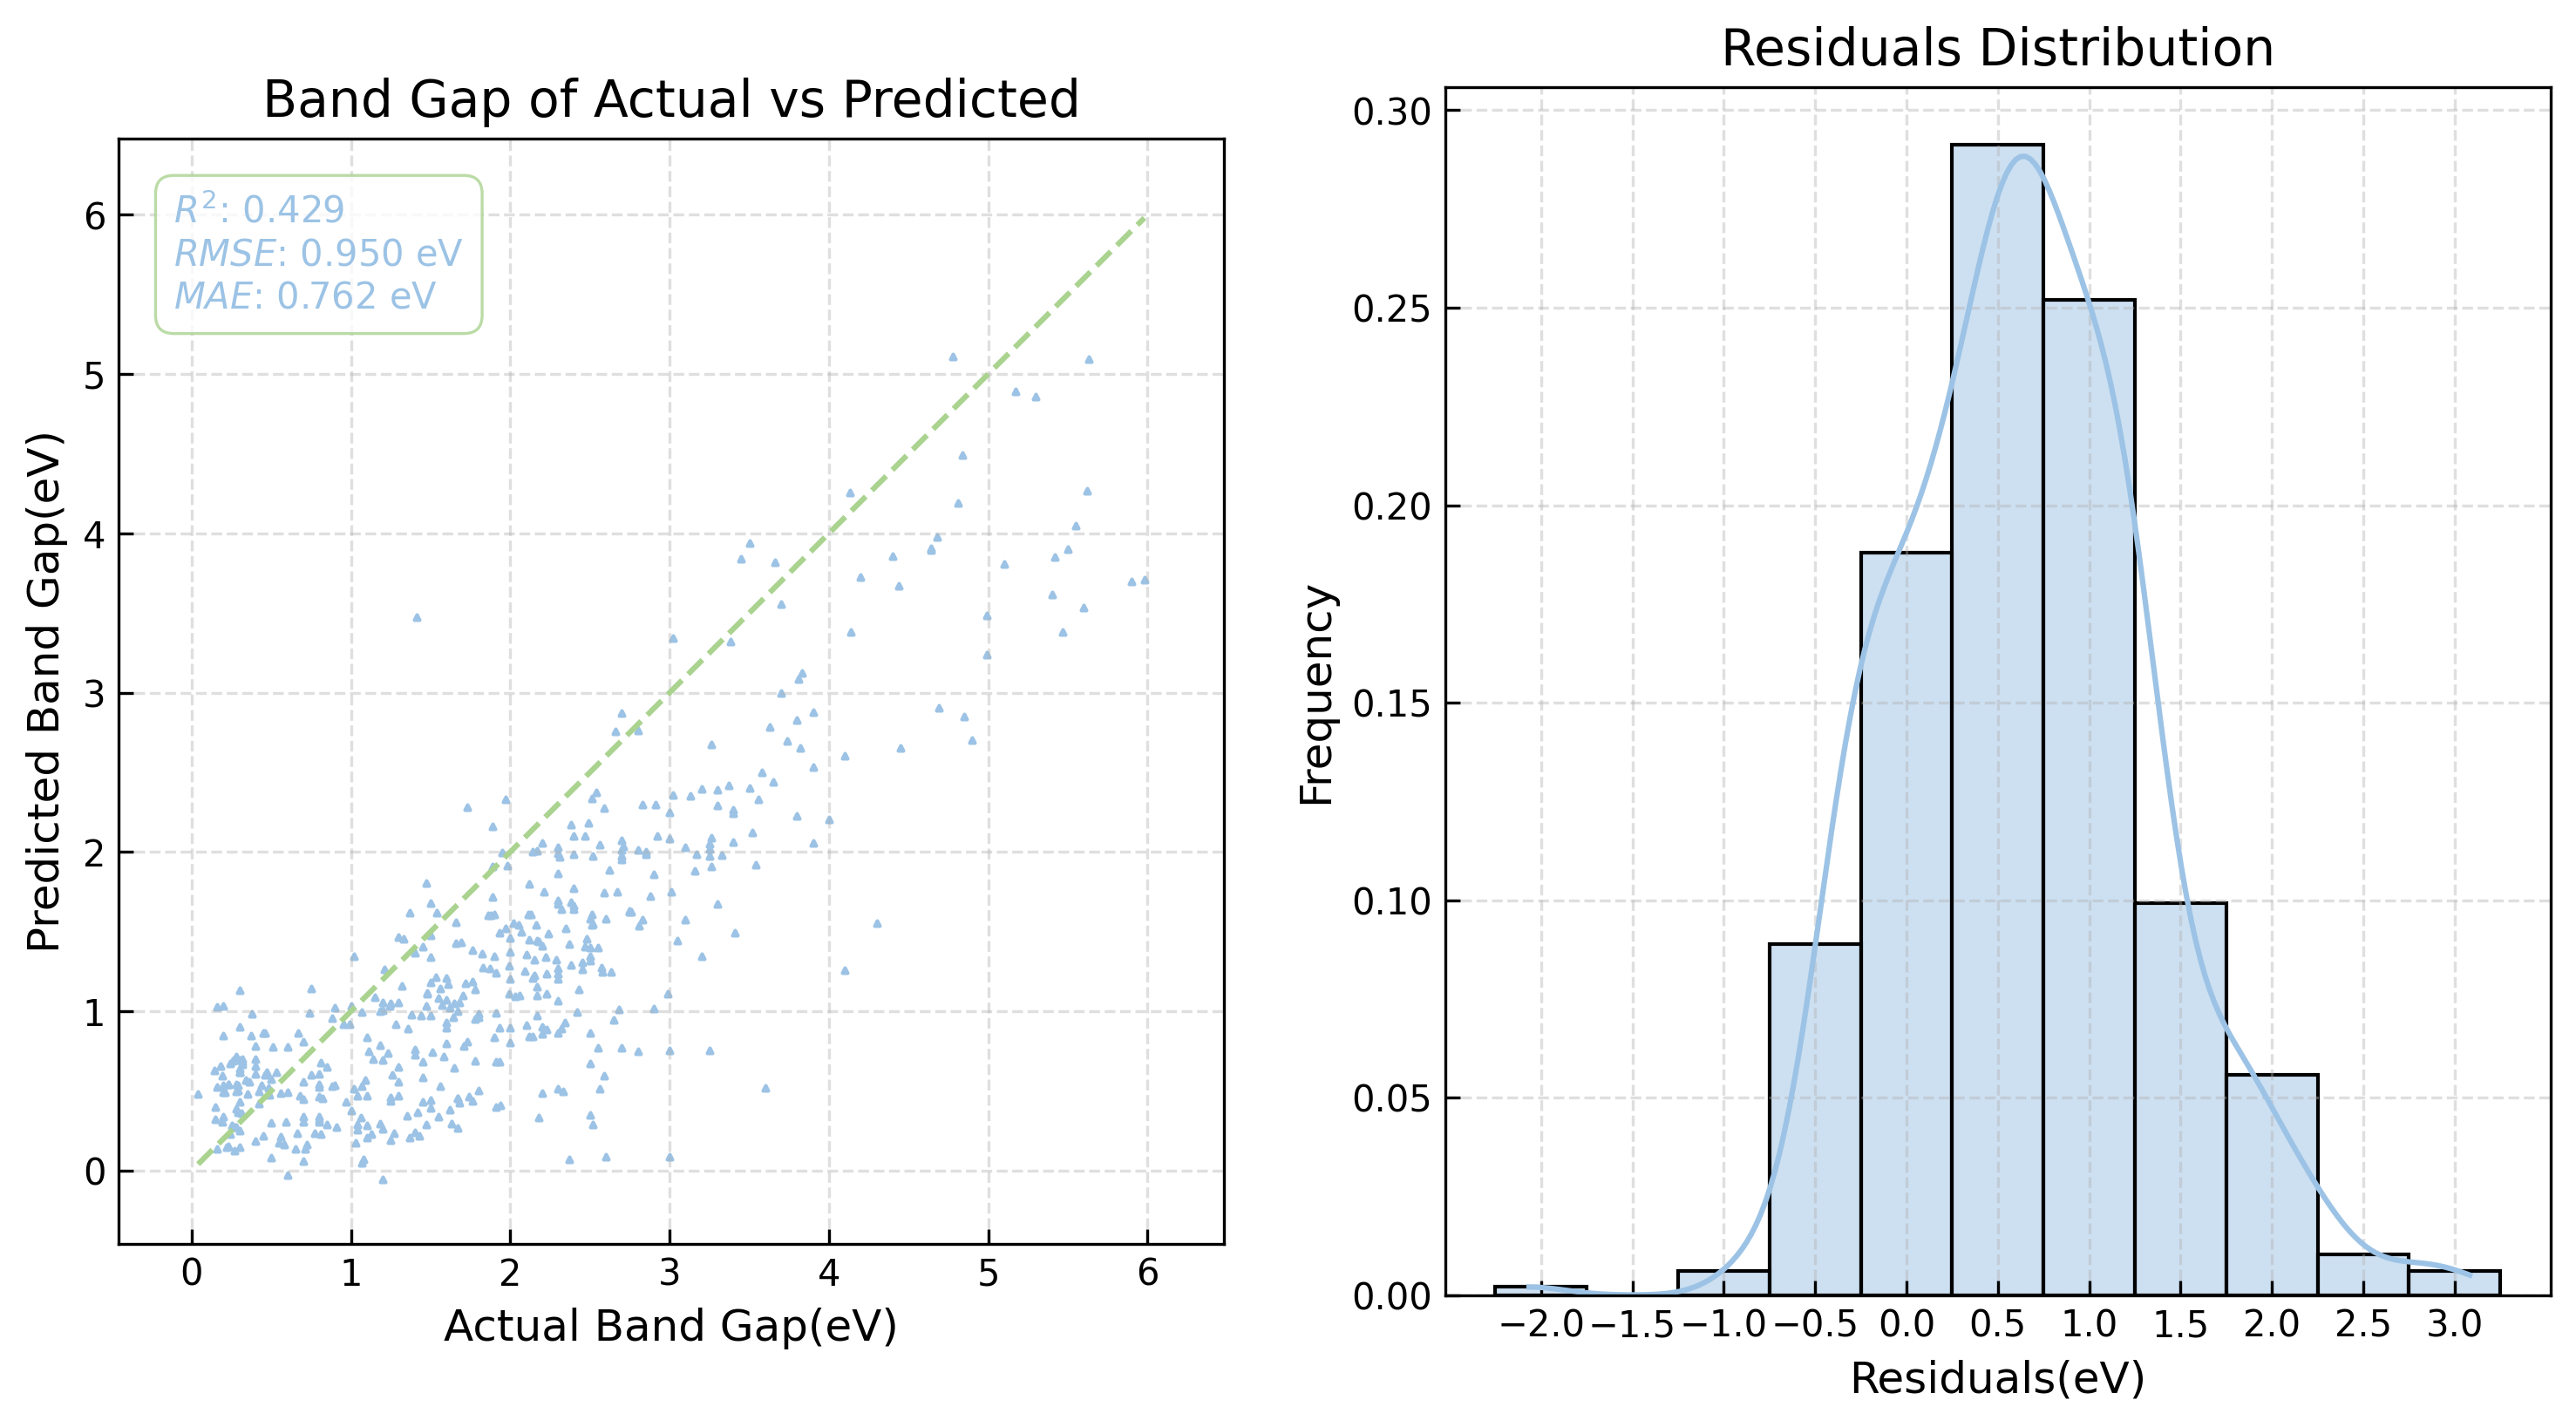


Model Evaluation Results:
Test set: R²: 0.4289 RMSE: 0.9497 MAE: 0.7624


In [31]:
# 
# Train the model with the best hyperparameters on the entire training set
# using the best hyperparameters from the random search
gbr_best = GradientBoostingRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=10,
    max_features=0.25,
    subsample=1.0,
    random_state=RANDOM_SEED
)
# record model metrics
model_metrics = pd.DataFrame(columns=['Model', 'Error_Type', 'Train_set', 'Test_set', 'R²', 'RMSE', 'MAE'])
# Train the model on dft data
print("#" * 100)
print(f"[DFT - {MODEL_NAME}] Training {MODEL_NAME} on DFT data:")
print("-" * 100)

dft_model = SingleModel(clone(gbr_best), random_state=RANDOM_SEED)
dft_model.train(dft_train_X, dft_train_y)

# evaluate on the dft train set
print(f"[Train_error] Evaluating DFT {MODEL_NAME} on DFT train set:")
metrics = dft_model.evaluate(dft_train_X, dft_train_y)
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,
'Error_Type': 'Train',
'Train_set': 'dft',
'Test_set': 'dft',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}

# evaluate on the dft test set
print(f"[Test DFT -> DFT] Evaluating DFT {MODEL_NAME} on DFT test set:")

metrics = dft_model.evaluate(dft_test_X, dft_test_y)
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,
'Error_Type': 'Test',
'Train_set': 'dft',
'Test_set': 'dft',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}
# evaluate on the exp test set
print(f"[Test DFT -> EXP] Evaluating DFT {MODEL_NAME} on EXP test set:")
metrics = dft_model.evaluate(exp_test_X, exp_test_y)
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,
'Error_Type': 'Test',
'Train_set': 'dft',
'Test_set': 'exp',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}

In [32]:
model_metrics.head()

,Model,Error_Type,Train_set,Test_set,R²,RMSE,MAE
0,GBR,Train,dft,dft,0.957047,0.306034,0.208795
1,GBR,Test,dft,dft,0.787756,0.680974,0.445992
2,GBR,Test,dft,exp,0.428864,0.949718,0.762366


### EXP Model

In [25]:
# using random search to find the best hyperparameters for the dft model
print(f"['EXP {MODEL_NAME}'] HP optimization begin...")

# create a pipeline with a scaler and the model
gbr_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('gbr', GradientBoostingRegressor(random_state=RANDOM_SEED))
])

# define the parameter distributions  for the KNN model(total 675 combinations)
param_distributions = {
    'gbr__n_estimators': [200, 300, 500],
    'gbr__learning_rate': [0.01, 0.05, 0.1],
    'gbr__max_depth': [3, 4, 5, 7, 10],
    'gbr__max_features': ['sqrt', 'log2', 0.25, 0.5, 1.0],
    'gbr__subsample': [0.5, 0.75, 1],
}
# create a KFold object for cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
# create a grid search CV object
# forget to assign metrics score, the default is R2 score
grid_search = GridSearchCV(estimator=gbr_pipe, param_grid=param_distributions,
                cv=kf, verbose=1, 
                scoring='neg_mean_squared_error', return_train_score=True,  n_jobs=-1)

# fit the model to the training data
grid_search.fit(exp_train_X, exp_train_y)


['EXP GBR'] HP optimization begin...
Fitting 5 folds for each of 675 candidates, totalling 3375 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('gbr',
                                        GradientBoostingRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'gbr__learning_rate': [0.01, 0.05, 0.1],
                         'gbr__max_depth': [3, 4, 5, 7, 10],
                         'gbr__max_features': ['sqrt', 'log2', 0.25, 0.5, 1.0],
                         'gbr__n_estimators': [200, 300, 500],
                         'gbr__subsample': [0.5, 0.75, 1]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=1)

In [26]:
# get the best hyperparameters
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")
best_score = np.sqrt(-grid_search.best_score_)
print(f"Best Cross-Validation RMSE: {best_score:.4f}")

# create a DataFrame to store the results
results = pd.DataFrame(grid_search.cv_results_)
results['test_rmse'] = np.sqrt(-results['mean_test_score'])
results['train_rmse'] = np.sqrt(-results['mean_train_score'])
# sort the results by test RMSE
results_sorted = results.sort_values('test_rmse')
results_sorted = results_sorted[['rank_test_score', 'param_gbr__n_estimators', 'param_gbr__max_depth', 
                                 'param_gbr__learning_rate', 'param_gbr__max_features', 'param_gbr__subsample', 'train_rmse', 'test_rmse']]
# save the results to a csv file
hp_path = os.path.join(current_path, 'hp_search')
os.makedirs(hp_path, exist_ok=True)
results_sorted.to_csv(os.path.join(hp_path, 'exp_hp_results.csv'), index=False)
results_sorted.head()

Best Hyperparameters: {'gbr__learning_rate': 0.05, 'gbr__max_depth': 5, 'gbr__max_features': 1.0, 'gbr__n_estimators': 500, 'gbr__subsample': 0.75}
Best Cross-Validation RMSE: 0.5602


,rank_test_score,param_gbr__n_estimators,param_gbr__max_depth,param_gbr__learning_rate,param_gbr__max_features,param_gbr__subsample,train_rmse,test_rmse
358,1,500,5,0.05,1.0,0.75,0.091745,0.560235
355,2,300,5,0.05,1.0,0.75,0.161465,0.563489
376,3,500,7,0.05,log2,0.75,0.035245,0.563680
339,4,500,5,0.05,0.25,0.50,0.133295,0.564200
367,5,500,7,0.05,sqrt,0.75,0.029568,0.564840


### Overfitting check

####################################################################################################
[EXP - GBR] Training GBR on EXP data:
----------------------------------------------------------------------------------------------------
Starting model training...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=  11.7s
Model training completed!
[Train_error] Evaluating EXP GBR on EXP train set:


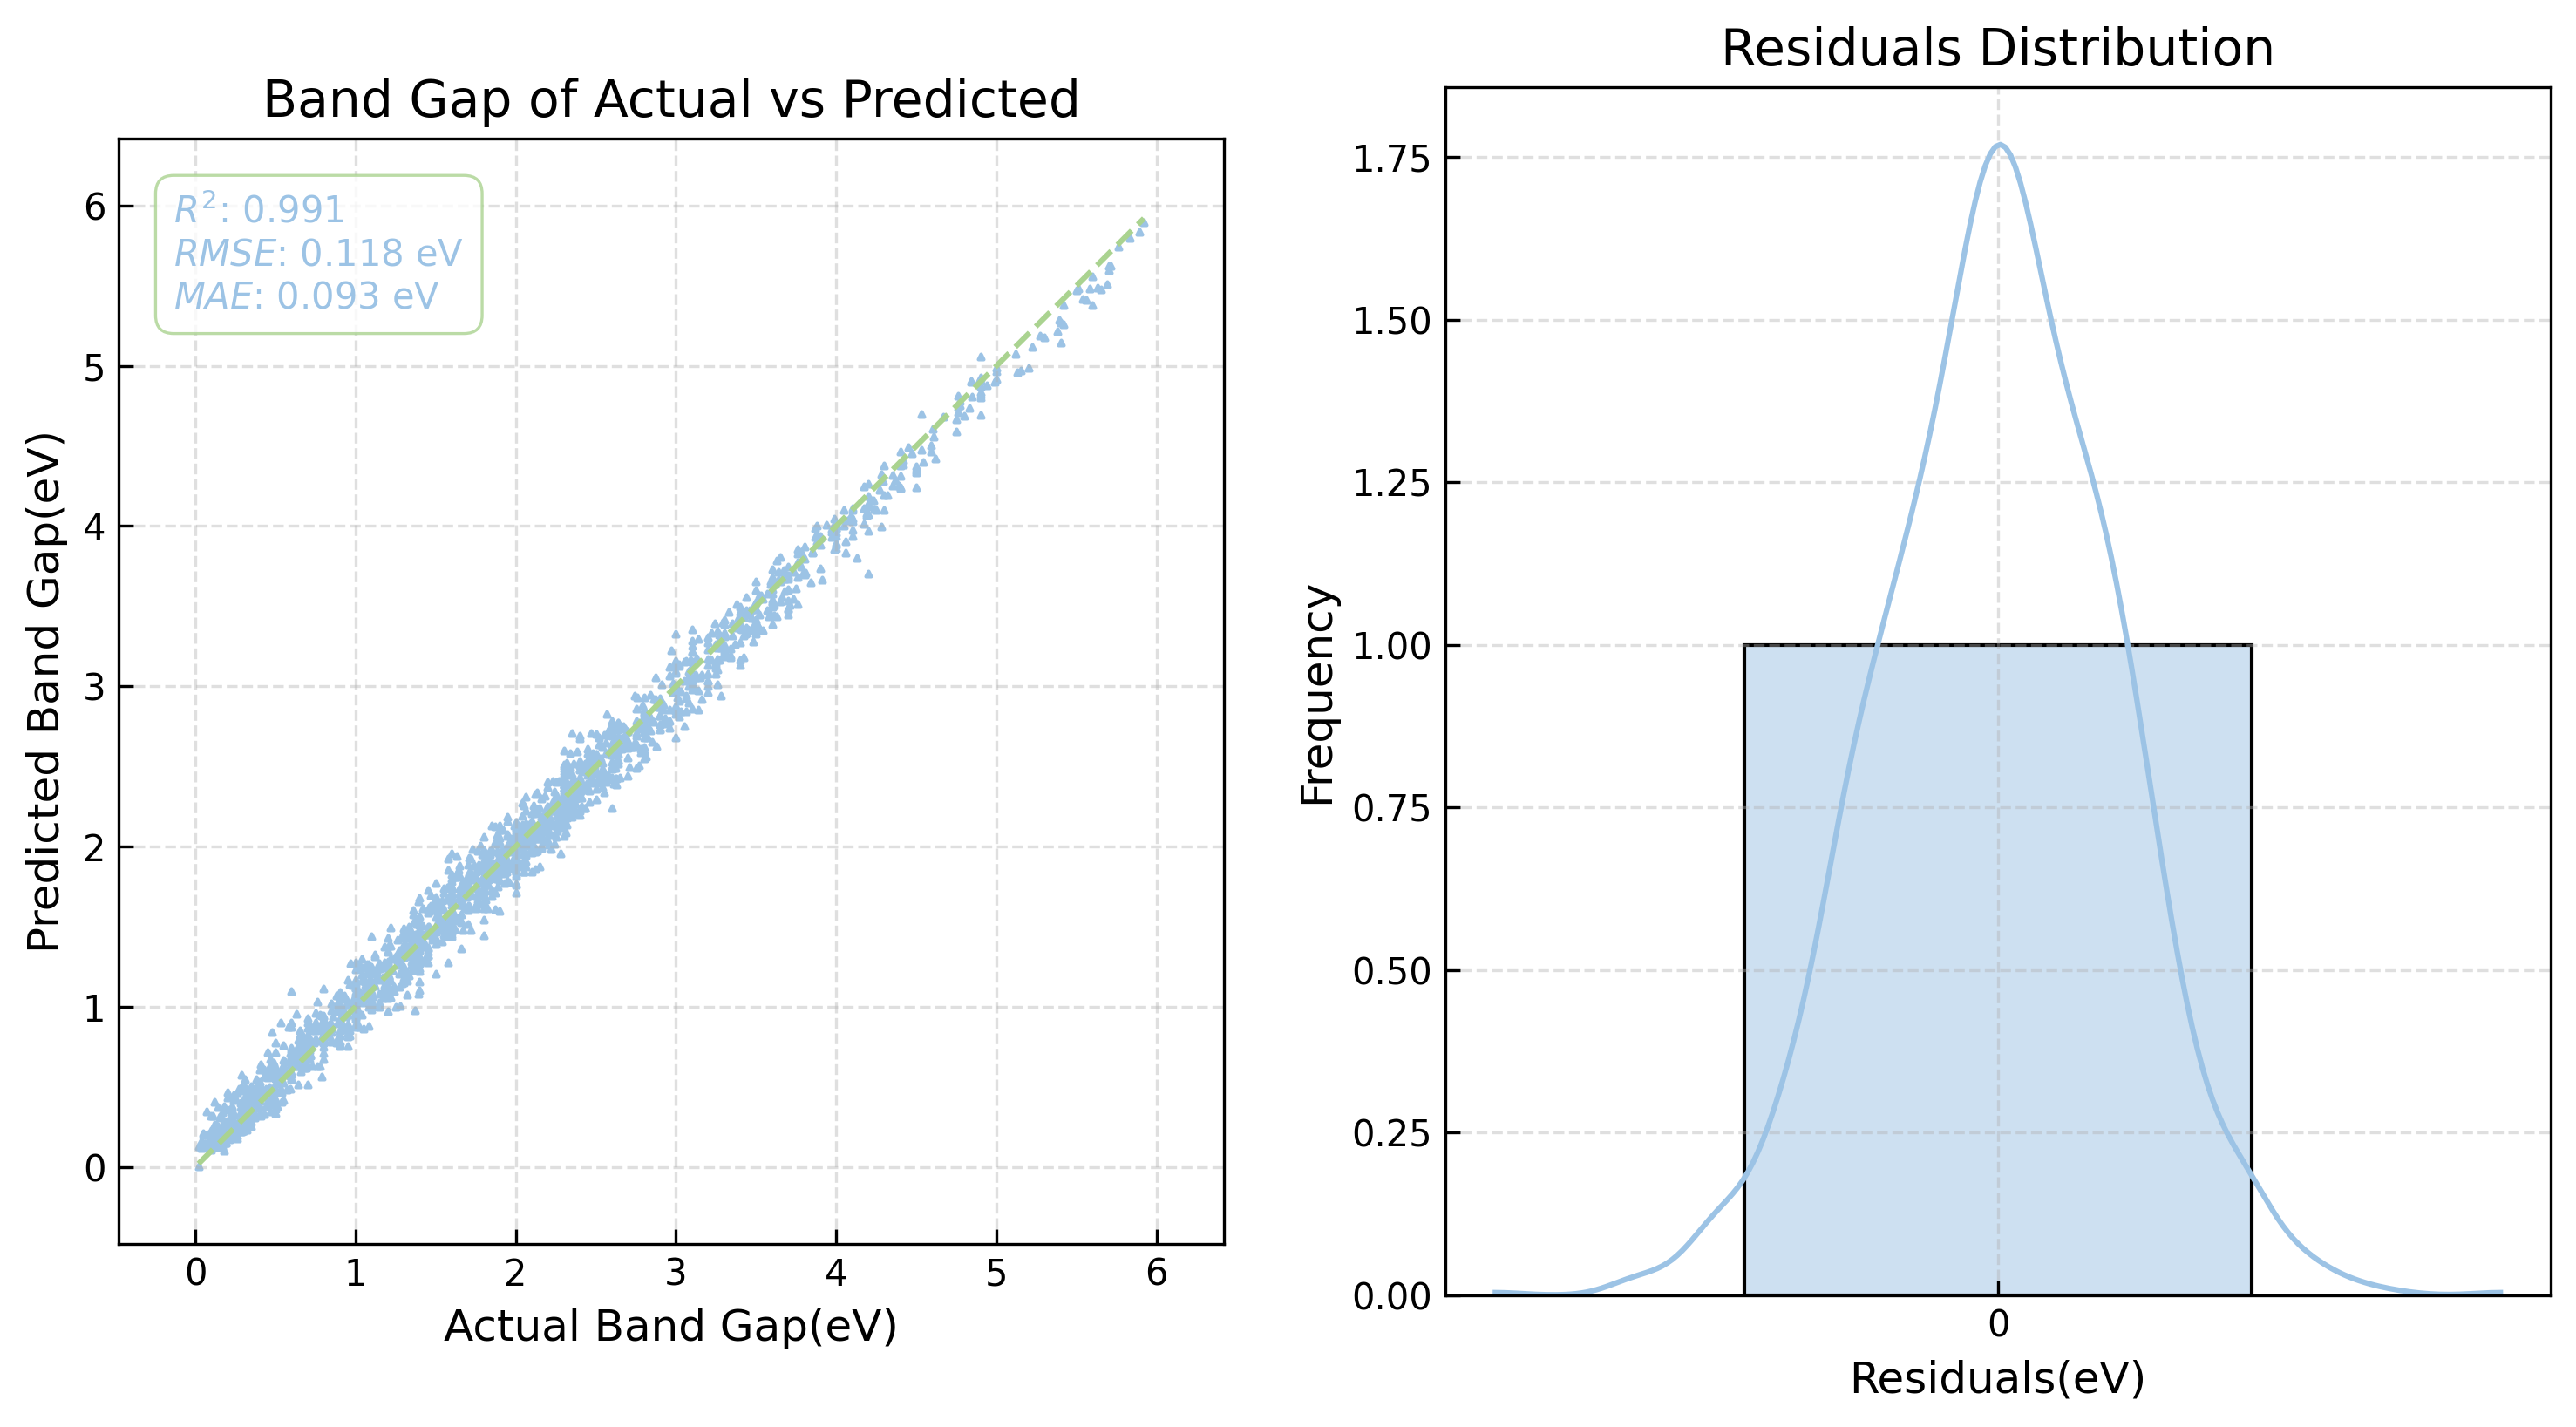


Model Evaluation Results:
Test set: R²: 0.9906 RMSE: 0.1177 MAE: 0.0928
[Test EXP -> EXP] Evaluating EXP GBR on EXP test set:


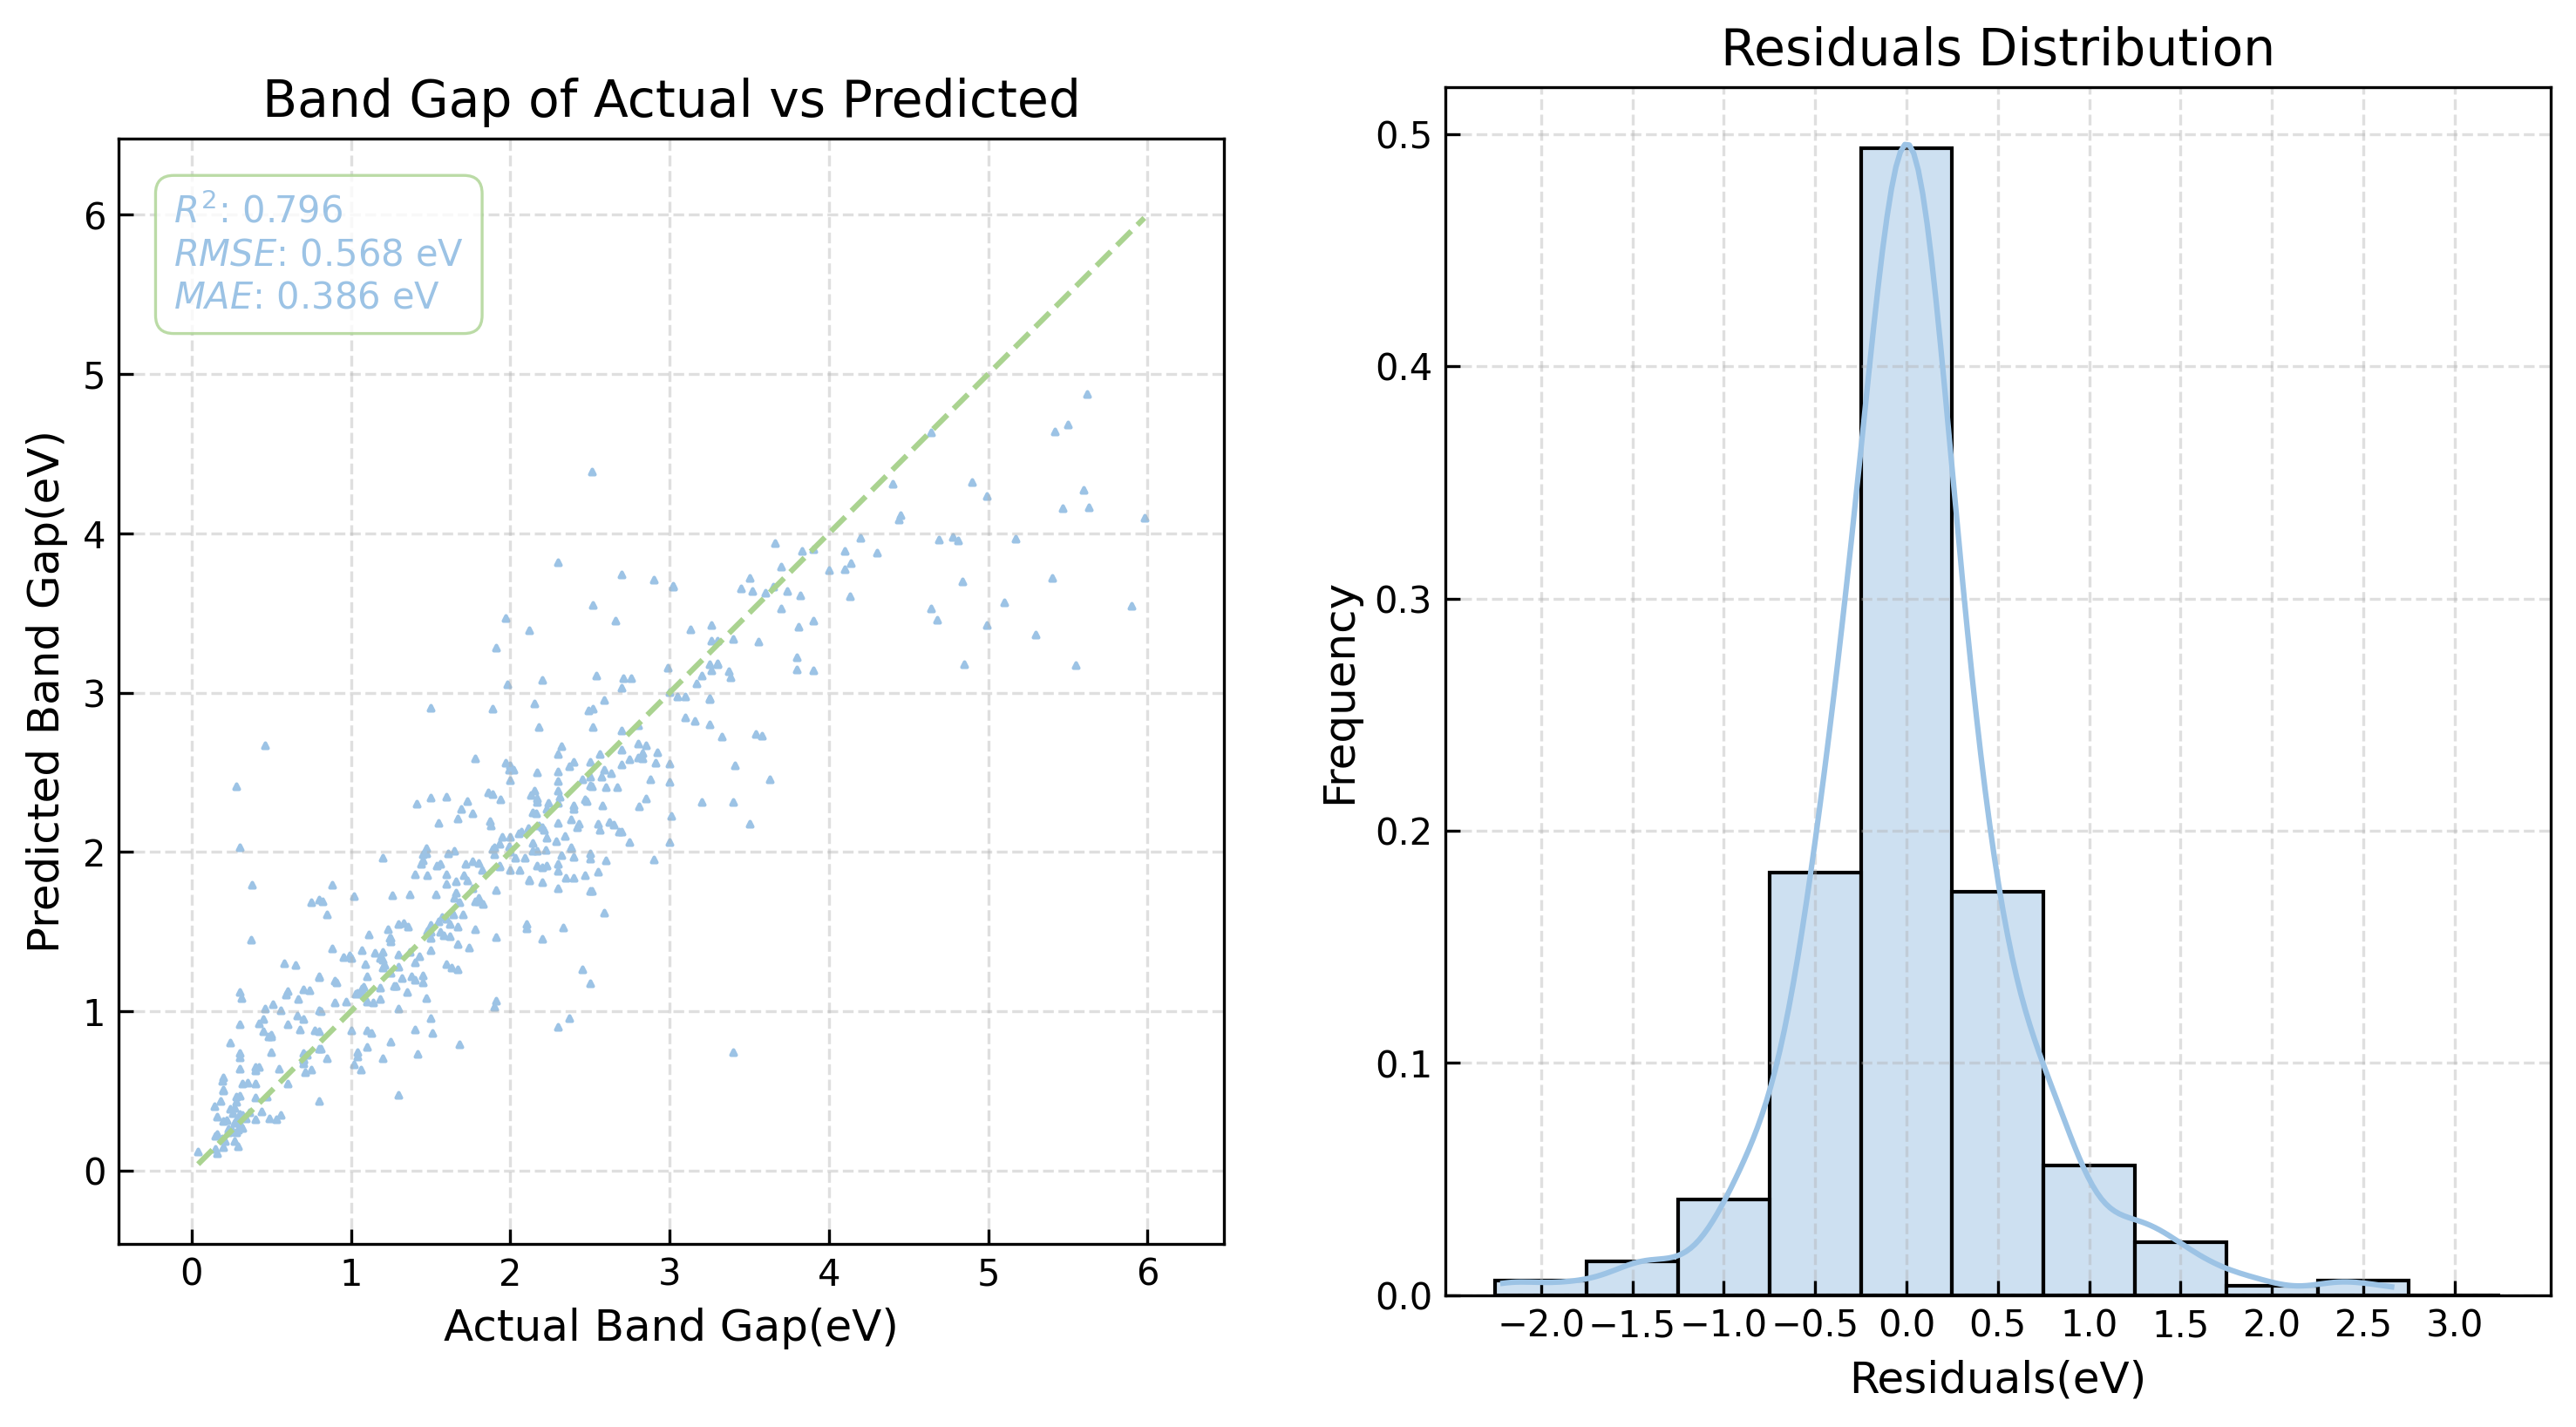


Model Evaluation Results:
Test set: R²: 0.7959 RMSE: 0.5678 MAE: 0.3862
[Test EXP -> DFT] Evaluating EXP GBR on DFT test set:


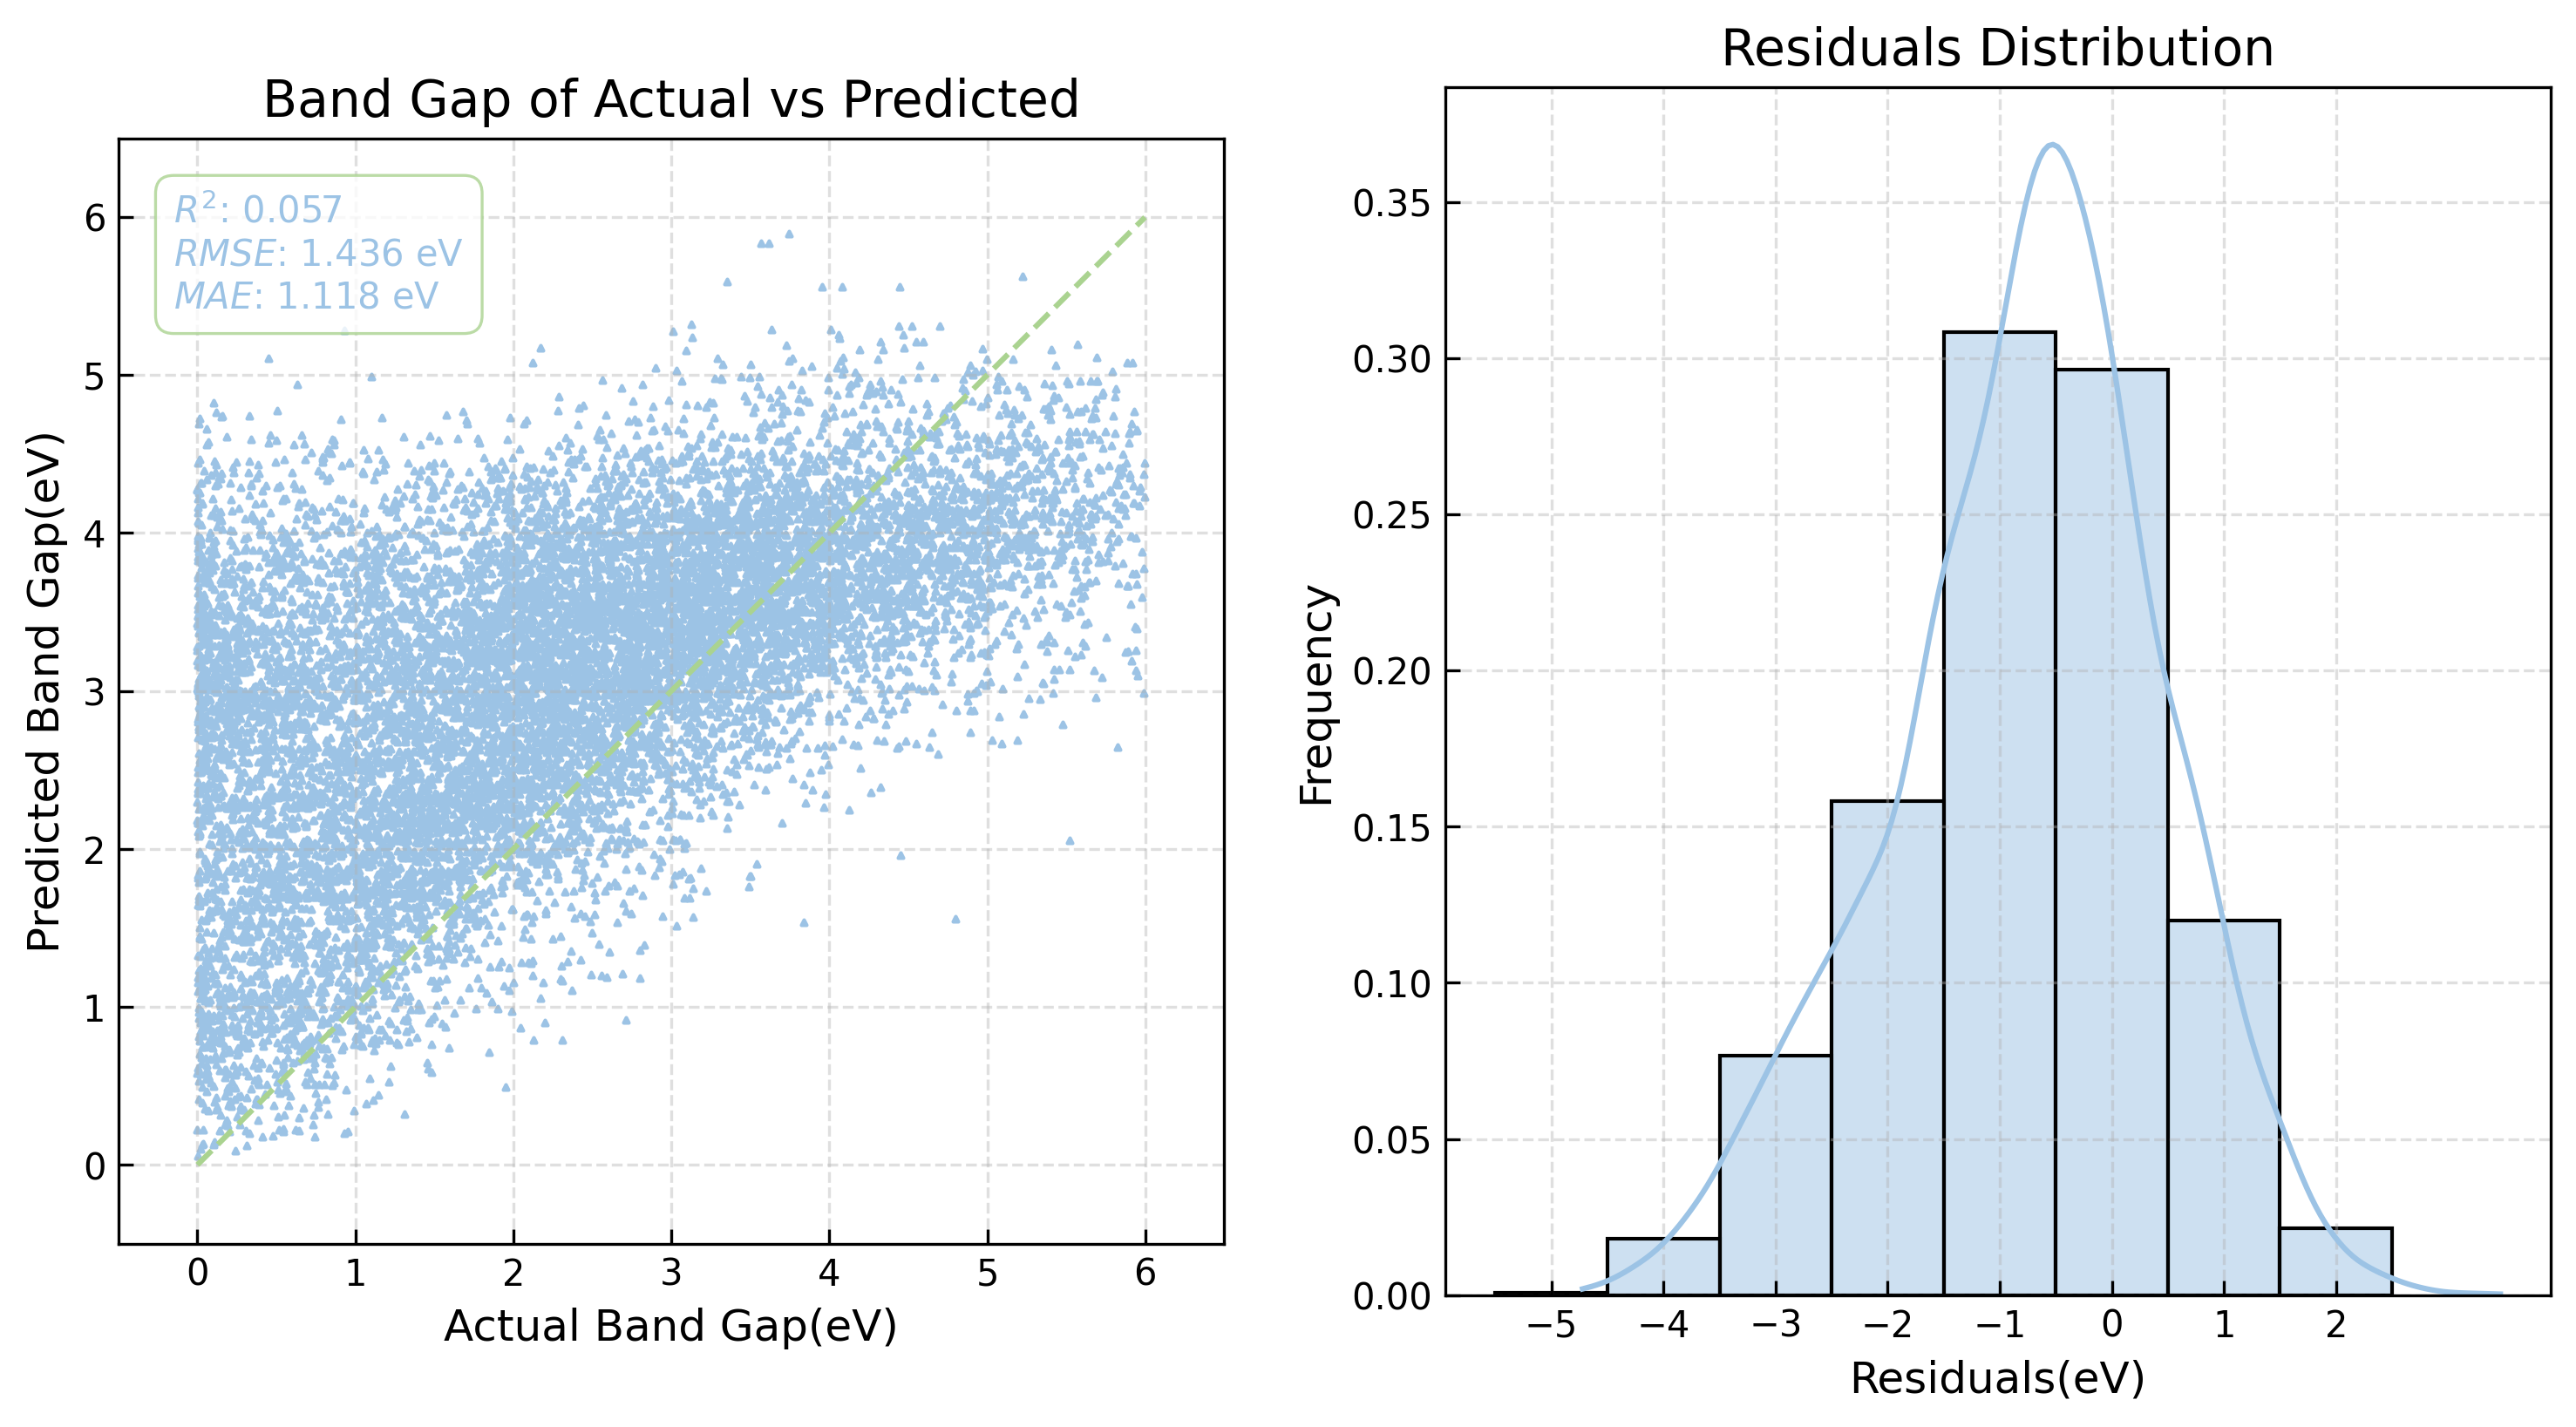


Model Evaluation Results:
Test set: R²: 0.0567 RMSE: 1.4356 MAE: 1.1177


In [27]:
# 
# Train the model with the best hyperparameters on the entire training set
# using the best hyperparameters from the random search
gbr_best = GradientBoostingRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    max_features=1.0,
    subsample=0.75,
    random_state=RANDOM_SEED
)

# record model metrics
model_metrics = pd.DataFrame(columns=['Model', 'Error_Type', 'Train_set', 'Test_set', 'R²', 'RMSE', 'MAE'])
# Train the model on dft data
print("#" * 100)
print(f"[EXP - {MODEL_NAME}] Training {MODEL_NAME} on EXP data:")
print("-" * 100)

exp_model = SingleModel(clone(gbr_best), random_state=RANDOM_SEED)
exp_model.train(exp_train_X, exp_train_y)

# evaluate on the dft train set
print(f"[Train_error] Evaluating EXP {MODEL_NAME} on EXP train set:")
metrics = exp_model.evaluate(exp_train_X, exp_train_y)
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,
'Error_Type': 'Train',
'Train_set': 'exp',
'Test_set': 'exp',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}

# evaluate on the dft test set
print(f"[Test EXP -> EXP] Evaluating EXP {MODEL_NAME} on EXP test set:")

metrics = exp_model.evaluate(exp_test_X, exp_test_y)
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,
'Error_Type': 'Test',
'Train_set': 'exp',
'Test_set': 'exp',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}
# evaluate on the exp test set
print(f"[Test EXP -> DFT] Evaluating EXP {MODEL_NAME} on DFT test set:")
metrics = exp_model.evaluate(dft_test_X, dft_test_y)
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,
'Error_Type': 'Test',
'Train_set': 'exp',
'Test_set': 'dft',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}

In [28]:
model_metrics.head()

,Model,Error_Type,Train_set,Test_set,R²,RMSE,MAE
0,GBR,Train,exp,exp,0.990595,0.117667,0.092831
1,GBR,Test,exp,exp,0.795863,0.567788,0.386249
2,GBR,Test,exp,dft,0.056739,1.435584,1.117748
